In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import accuracy_score 
%matplotlib inline

In [2]:
# There are a total of 223 test items (probe test+ post burin-in test) here, assume the worst burn-in test item as my target variable.
# that is, the variable that needs to be predicted, and the remaining 222 test items are used as feature variables.

# The feature variable here is not the feature variable of a wafer, but the feature variable of the whole lot where the lot contains 23 wafers (different X and Y). 
# I need to predict the worst burn-in test result in the lot based on the feature variables of the 23 wafers.
# Already wafer-center for both porbe test and post burn-in test.

df = pd.read_csv("XGBoost_probe_postbi_combine.csv", sep=",")
df

,WaferID,X,Y,PROBE_TEST_1,PROBE_TEST_2,PROBE_TEST_3,PROBE_TEST_4,PROBE_TEST_5,PROBE_TEST_6,PROBE_TEST_7,...,BI_TEST_143,BI_TEST_144,BI_TEST_145,BI_TEST_146,BI_TEST_147,BI_TEST_148,BI_TEST_149,BI_TEST_150,BI_TEST_151,BI_TEST_153
0,1,24,10,3.334982,41856,0.001060,41888,2.126256,41824,3.330742,...,24.219251,24.292342,24.181751,24.199713,24.157109,-0.153859,60.517315,0.680965,0.224883,1008
1,1,25,10,3.348421,43168,0.001053,43200,2.102923,43136,3.335789,...,24.336232,24.338244,24.334555,24.421146,24.268527,-0.147298,62.760395,0.681383,0.224883,1008
2,1,37,71,3.353310,44096,0.000000,44096,2.120370,44064,3.352265,...,24.122191,23.991690,23.893448,23.968834,24.036808,-0.221837,71.865441,0.679204,0.196518,1327
3,1,37,72,3.336842,43264,0.000000,43264,2.069124,43232,3.333684,...,23.970471,23.951021,24.045510,24.199602,24.001090,-0.263793,74.955620,0.681727,0.196518,1327
4,2,24,10,3.313043,38976,-0.001087,38944,4.163834,38912,3.302174,...,24.116373,24.145926,24.049150,24.104367,24.142417,-0.154594,56.352870,0.680578,0.220985,2181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,23,14,65,3.328421,42048,0.000000,42048,2.052231,42016,3.325263,...,24.490528,24.418961,24.480982,24.368059,24.366695,-0.183609,64.285152,0.678941,0.260249,14713
329,23,15,65,3.338947,42368,0.000000,42368,2.045867,42336,3.327368,...,24.531082,24.535837,24.556275,24.452069,24.439174,-0.180175,63.416723,0.677039,0.260249,14713
330,23,12,66,3.309441,41920,0.000000,41920,4.260740,41856,3.315734,...,24.366222,24.314304,24.343817,24.405072,24.333394,-0.179594,65.798660,0.683545,0.260249,14713
331,23,14,66,3.340909,42944,0.000000,42944,2.076541,42912,3.324126,...,24.490209,24.551078,24.478182,24.451718,24.527895,-0.179119,64.073749,0.675993,0.260249,14713


In [3]:
# Preliminary predictions
# Before doing feature extraction, I used the original feature variables to train the model by XGBoos method (both with regression and classification concept)
# Used XGBoost's parameter settings to see the performance of the model.
# First I create training and test sets, then make predictions: 
# random_state = 0 to ensure the reproducibility

X = df.loc[:, df.columns !=  'Target'] 
y = df.loc[:, df.columns == 'Target']
print(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train)
print(X_test)
print(y_train)
print(y_test) 

     WaferID   X   Y  PROBE_TEST_1  PROBE_TEST_2  PROBE_TEST_3  PROBE_TEST_4  \
0          1  24  10      3.334982         41856      0.001060         41888   
1          1  25  10      3.348421         43168      0.001053         43200   
2          1  37  71      3.353310         44096      0.000000         44096   
3          1  37  72      3.336842         43264      0.000000         43264   
4          2  24  10      3.313043         38976     -0.001087         38944   
..       ...  ..  ..           ...           ...           ...           ...   
328       23  14  65      3.328421         42048      0.000000         42048   
329       23  15  65      3.338947         42368      0.000000         42368   
330       23  12  66      3.309441         41920      0.000000         41920   
331       23  14  66      3.340909         42944      0.000000         42944   
332       23  15  66      3.346875         43552      0.000000         43552   

     PROBE_TEST_5  PROBE_TEST_6  PROBE_

In [4]:
# The key point is not to do feature extraction, directly set the default parameter of XGBoost

xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

y_train_pred1 = xgb_model1.predict(X_train)
y_test_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train, y_train_pred1))
print('Test r2 score: ', r2_score(y_test, y_test_pred1))
train_mse1 = mean_squared_error(y_train, y_train_pred1)
test_mse1 = mean_squared_error(y_test, y_test_pred1)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9999948598635676
Test r2 score:  0.8696620493512542
Train RMSE: 0.0004
Test RMSE: 0.0655


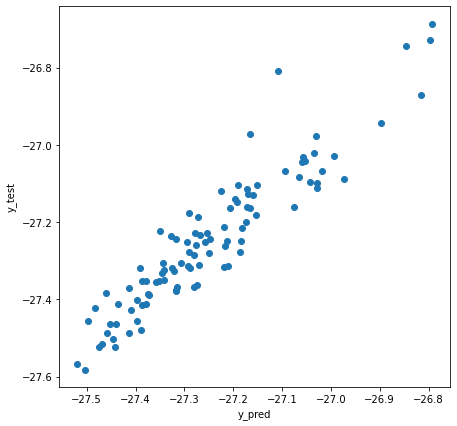

In [5]:
# Visualization

plt.figure(figsize=(7, 7))
plt.ylabel("y_test")
plt.xlabel("y_pred")
plt.scatter(y_test_pred1, y_test)

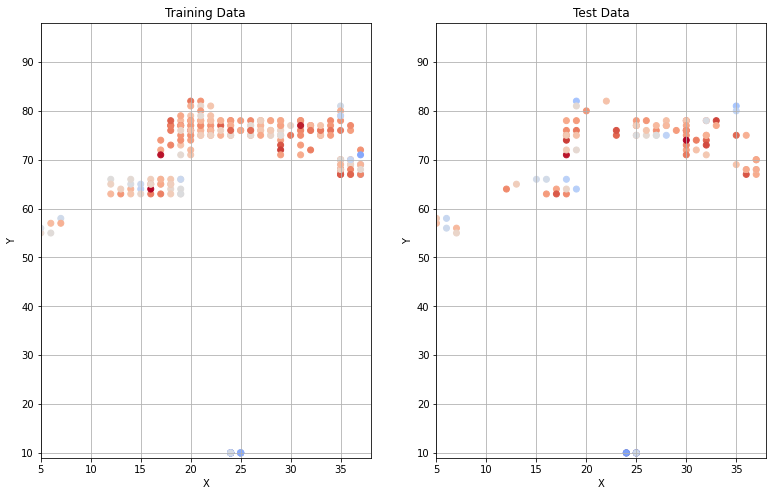

In [6]:
# Feature extraction
# Need to do a correct study of all the feature variables when doing feature extraction. 
# Some feature variables may need to be combined, and some feature variables need to be decomposed. I have to expand more than current feature variables. 
# First need to check the data distribution of these characteristic variables by histogram.
# look at the two characteristics of wafer coordinates (X and Y). They are the geographic coordinates of the wafer.
# Using these two features can provide excellent visualization by the worst post burn-in result.

plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([9, 98])
ax.set_autoscalex_on(False)
ax.set_xlim([5, 38])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X_train["X"],
            X_train["Y"],
            cmap="coolwarm",
            c=y_train["Target"] / y_train["Target"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Test Data")
ax.set_autoscaley_on(False)
ax.set_ylim([9, 98])
ax.set_autoscalex_on(False)
ax.set_xlim([5, 38])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X_test["X"],
            X_test["Y"],
            cmap="coolwarm",
            c=y_test["Target"] / y_test["Target"].max())
_ = plt.plot()

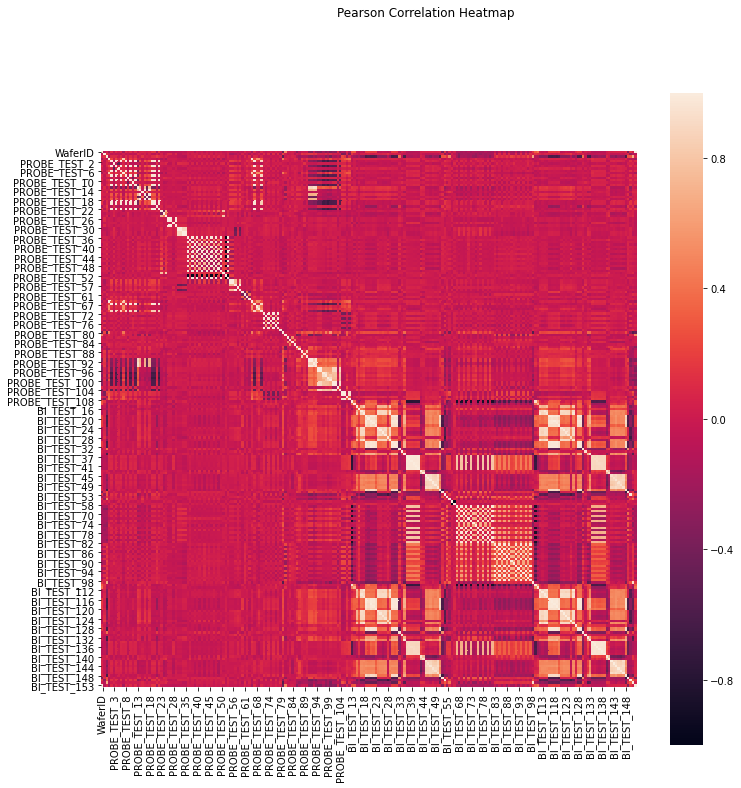

In [7]:
# Create a heat map of the correlation coefficient matrix to see the correlation between the feature variables:

import seaborn as sns
pd.set_option('precision',2)
plt.figure(figsize=(12, 12))
sns.heatmap(df.drop(['Target'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.savefig('Pearson Correlation Heatmap.png')
plt.show();

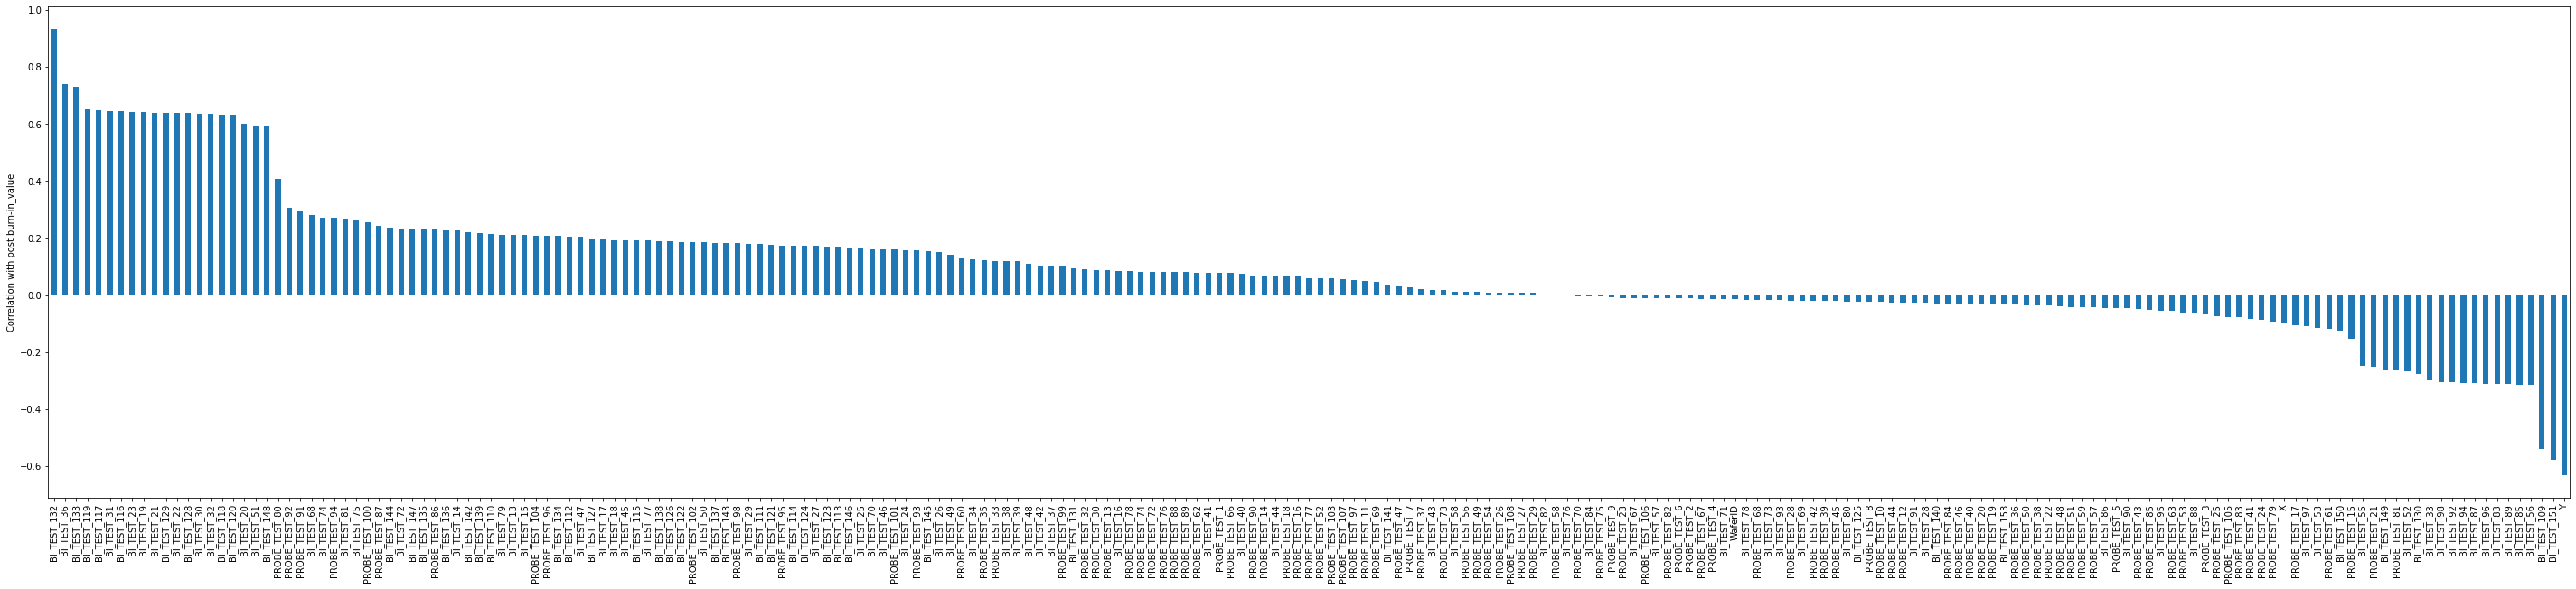

In [8]:
# It can be seen from the heat map of the above correlation coefficient matrix that post burn-in test items have a strong positive correlation with each other than probe test items.
# look at the correlation between the feature variable and the target variable:

corr_with_Target_value = df.corr()["Target"].sort_values(ascending=False)
plt.figure(figsize=(50,10))
plt.ylabel('Correlation with post burn-in_value')
corr_with_Target_value.drop("Target").plot.bar()
plt.savefig('Correlation value.png')
plt.show(); 

In [9]:
# Synthetic features, by sum top 3 correlation post burn-in test items (BI_TEST_132,BI_TEST_36, BI_TEST_33)
# Explore the relationship between Synthetic features and Target value

df["Synthetic feature"] =(df['BI_TEST_132'] + df['BI_TEST_36'] + df['BI_TEST_133'])
df["Synthetic feature"]=df["Synthetic feature"]/3
print(df["Synthetic feature"])
print(df)

0     -26.64
1     -26.61
2     -27.10
3     -27.31
4     -26.99
       ...  
328   -27.15
329   -27.10
330   -27.03
331   -27.03
332   -27.06
Name: Synthetic feature, Length: 333, dtype: float64
     WaferID   X   Y  PROBE_TEST_1  PROBE_TEST_2  PROBE_TEST_3  PROBE_TEST_4  \
0          1  24  10          3.33         41856      1.06e-03         41888   
1          1  25  10          3.35         43168      1.05e-03         43200   
2          1  37  71          3.35         44096      0.00e+00         44096   
3          1  37  72          3.34         43264      0.00e+00         43264   
4          2  24  10          3.31         38976     -1.09e-03         38944   
..       ...  ..  ..           ...           ...           ...           ...   
328       23  14  65          3.33         42048      0.00e+00         42048   
329       23  15  65          3.34         42368      0.00e+00         42368   
330       23  12  66          3.31         41920      0.00e+00         41920   
331 

In [10]:
#Next use the new feature set with synthetic features (by group top correlation test items)to train our XGBoost model again

X = df.loc[:, df.columns !=  'Target'] 
y = df.loc[:, df.columns == 'Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

xgb_model2 = XGBRegressor()
xgb_model2.fit(X_train, y_train, verbose=False)

y_train_pred2 = xgb_model2.predict(X_train)
y_test_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train, y_train_pred2))
print('Test r2 score: ', r2_score(y_test, y_test_pred2))
train_mse2 = mean_squared_error(y_train, y_train_pred2)
test_mse2 = mean_squared_error(y_test, y_test_pred2)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.9999943800854812
Test r2 score:  0.861673815963637
Train RMSE: 0.0004
Test RMSE: 0.0674


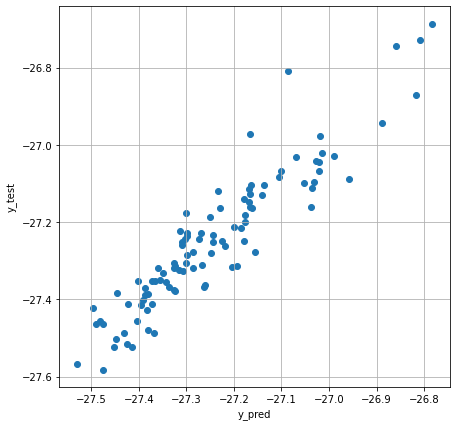

In [11]:
# From the above prediction results, the RMSE on the test set didn't been reduced from 0.0655 to 0.0675
# Guess the test items sum up already is lower the correlation

# Check wafer Y corridinate effect, from burn-in purpose pick up the die from each wafer top or bottom
# Let's first look at the data distribution of the dimensions and target variables:
    
plt.figure(figsize=(7, 7))
plt.grid()
plt.ylabel("y_test")
plt.xlabel("y_pred")
plt.scatter(y_test_pred2, y_test)
plt.show()

count    333.00
mean      64.65
std       21.80
min       10.00
25%       65.00
50%       75.00
75%       77.00
max       82.00
Name: Y, dtype: float64


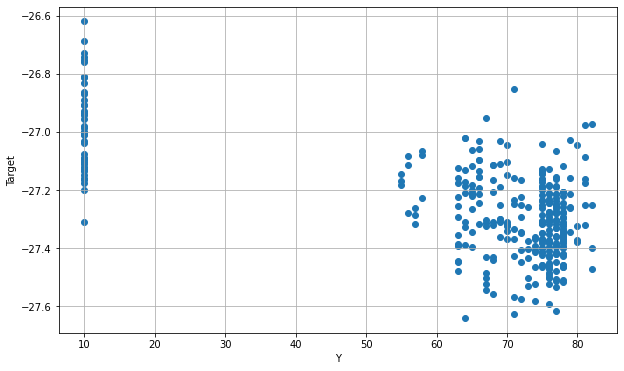

In [12]:
# From the perspective of the distribution of dimensions, assume wafer coordinate Y is slightly sensitive to the worst bin failure. 
# Then decompose wafer coordinate Y into two intervals, Y(5 to 15) and Y (55 to 85) will be stored as one-hot

print(df.Y.describe())
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('Y')
plt.ylabel('Target')
plt.scatter(df["Y"], df["Target"])

In [13]:
X = df.loc[:, df.columns !=  'Target'] 
y = df.loc[:, df.columns == 'Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Y_RANGES = zip(range(5, 15), range(55, 85))
for r in Y_RANGES:
    X_train["lat_%d_to_%d" % r] = X_train["Y"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)
    
Y_RANGES = zip(range(5, 15), range(55, 85))
for r in Y_RANGES:
    X_test["lat_%d_to_%d" % r] = X_test["Y"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)

X_train = X_train.loc[:,X_train.columns !=  'Y']    
X_test = X_test.loc[:,X_test.columns !=  'Y']

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [14]:
xgb_model3 = XGBRegressor()
xgb_model3.fit(X_train, y_train, verbose=False)

y_train_pred3 = xgb_model3.predict(X_train)
y_test_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train, y_train_pred3))
print('Test r2 score: ', r2_score(y_test, y_test_pred3))
train_mse3 = mean_squared_error(y_train, y_train_pred3)
test_mse3 = mean_squared_error(y_test, y_test_pred3)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

Train r2 score:  0.9999949389112046
Test r2 score:  0.8566688507098852
Train RMSE: 0.0004
Test RMSE: 0.0686


count    333.00
mean       0.19
std        0.02
min        0.14
25%        0.17
50%        0.19
75%        0.20
max        0.26
Name: BI_TEST_43, dtype: float64


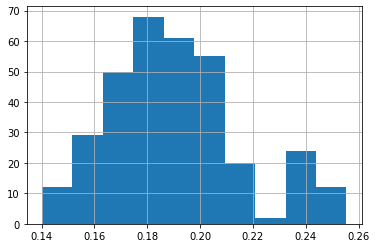

In [15]:
# Use BI_TEST_43 (with good and bad result) to seperate
print(df.BI_TEST_43.describe())
df.BI_TEST_43.hist()

In [16]:
#bucket_0 (< 0.175)
#bucket_1 (0.175 ~ 0.22)
#bucket_2 (> 0.22)

X = df.loc[:, df.columns !=  'Target'] 
y = df.loc[:, df.columns == 'Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

for r in ((-0.8, 0.175),(0.175, 0.22),(0.22, 0.3)):
    X_train["pop_%d_to_%d" % r] = X_train["BI_TEST_43"].apply(lambda l:0.01 if l>=r[0] and l<r[1] else 0.0)
    
for r in ((-0.8, 0.175),(0.175, 0.22),(0.22, 0.3)):
    X_test["pop_%d_to_%d" % r] = X_test["BI_TEST_43"].apply(lambda l:0.1 if l>=r[0] and l<r[1] else 0.0)
    
X_train = X_train.loc[:,X_train.columns !=  'BI_TEST_43']    
X_test = X_test.loc[:,X_test.columns !=  'BI_TEST_43']

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [17]:
xgb_model4 = XGBRegressor()
xgb_model4.fit(X_train, y_train, verbose=False)

y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_pred4,y_test))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.9999934040677946
Test r2 score:  0.8259931383031068
Train RMSE: 0.0004
Test RMSE: 0.0675


In [18]:
# Sum up
# Feature synthesis and feature bucket, only explain that feature bucketing is not ideal for our dataset or for XGBoost.
# The effect of using feature bucketing is still a good method, but it is slightly worse than XGBoost.